In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from os.path import dirname, join
from scipy.interpolate import RegularGridInterpolator
from dateutil.parser import parse

# Earthdata
from earthdata import DataCollections, DataGranules, Auth, Store

# Credentials to interact with CMR
First we initialize Auth() to get the cloud credentials, if we have a `.netrc` file this can be done automatically

In [2]:
auth = Auth().login(strategy='netrc')
if auth.authenticated is None:
    # we ask for credentials
    auth.login()
auth

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/04/2022


# Define important parameters

In [3]:
# beaufort sea region
lonrange = [-160, -130]
latrange = [68, 80]
bounding_box = (lonrange[0], latrange[0], lonrange[1], latrange[1])
# Data collection short name
ShortName_sss = "SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5"
ShortName_sst = "AVHRR_OI-NCEI-L4-GLOB-v2.1"

In [4]:
# Severine:
insitu_dir=Path('/home/jovyan/Data/SASSIE/collocation/insitu/')  
satsss_dir=Path('/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/') 
satsst_dir=Path('/home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/') 
output_dir=Path('./data/output/') 

#### Querying CMR using `earthdata` to get the `concept_id` for the cloud hosted collection

In [5]:
# See: https://github.com/nsidc/earthdata
CollectionQuery = DataCollections().short_name(ShortName_sss).cloud_hosted(True)
collections = CollectionQuery.get()
for collection in collections:
    concept_id_sss = collection.concept_id()
    print(concept_id_sss)
    
CollectionQuery = DataCollections().short_name(ShortName_sst).cloud_hosted(True)
collections = CollectionQuery.get()
for collection in collections:
    concept_id_sst = collection.concept_id()
    print(concept_id_sst)

C2208422957-POCLOUD
C2036881712-POCLOUD


# Load in situ SIZRS file for 1 year

In [6]:
filename=str(insitu_dir) + '/SIZRS_2016.nc'
insitu = xr.open_dataset(filename)
insitu

<xarray.Dataset>
Dimensions:  (t: 26)
Coordinates:
    x        (t) float64 ...
    y        (t) float64 ...
    z        float64 ...
  * t        (t) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:39:00
Data variables:
    SSS      (t) float64 ...
    SST      (t) float64 ...

In [7]:
# round the time to the closest day
days_from_insitu = pd.to_datetime(insitu.t).round('D')
days = days_from_insitu.values
days

array(['2016-06-16T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2016-06-16T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2016-07-14T00:00:00.000000000', '2016-07-14T00:00:00.000000000',
       '2016-07-14T00:00:00.000000000', '2016-07-14T00:00:00.000000000',
       '2016-07-14T00:00:00.000000000', '2016-08-19T00:00:00.000000000',
       '2016-08-19T00:00:00.000000000', '2016-09-15T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-09-15T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-09-15T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-09-16T00:00:00.000000000',
       '2016-09-16T00:00:00.000000000', '2016-09-16T00:00:00.000000000',
       '2016-10-07T00:00:00.000000000', '2016-10-07T00:00:00.000000000',
       '2016-10-07T00:00:00.000000000', '2016-10-07T00:00:00.000000000',
       '2016-10-07T00:00:00.000000000', '2016-10-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [8]:
# we use a Set to avoid repeating queries to the same day to download the data
date_ranges = set()
for day in days:
    start_date = str(day)
    end_date = str(day + np.timedelta64(1, 'D'))
    # or end_date = str(day + np.timedelta64(1, 'D') - np.timedelta64(1, 's')) for 23:59:59 of the same day, the search on CMR is the same.
    date_range = (start_date, end_date)
    date_ranges.add(date_range)
date_ranges

{('2016-06-16T00:00:00.000000000', '2016-06-17T00:00:00.000000000'),
 ('2016-07-14T00:00:00.000000000', '2016-07-15T00:00:00.000000000'),
 ('2016-08-19T00:00:00.000000000', '2016-08-20T00:00:00.000000000'),
 ('2016-09-15T00:00:00.000000000', '2016-09-16T00:00:00.000000000'),
 ('2016-09-16T00:00:00.000000000', '2016-09-17T00:00:00.000000000'),
 ('2016-10-07T00:00:00.000000000', '2016-10-08T00:00:00.000000000')}

# Download from CMR the granules we want
Since `SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5` is an **8-day running mean** a query to a given day will overlap with 
8 different days and we are only interested in the mid date.

In [9]:
store = Store(auth) 
for dt in date_ranges:
    GranuleQuery = DataGranules().parameters(
        concept_id=concept_id_sss,
        bounding_box=bounding_box,
        temporal=dt)
    granules = GranuleQuery.get()
    # Since our query at this point is for one day only
    dt_middate = parse(str(dt[0])).strftime('%Y%m%d')
    for i in range(0,len(granules)): #granule in granules:
        # The native_id has the mid_date encoded in this case
        if dt_middate in granules[i]["meta"]["native-id"]:
            files = store.get(granules[i:i+1], str(satsss_dir)+'/')
    GranuleQuery = DataGranules().parameters(
        concept_id=concept_id_sst,
        bounding_box=bounding_box,
        temporal=dt)
    granules = GranuleQuery.get()
    # Since our query at this point is for one day only
    dt_middate = parse(str(dt[0])).strftime('%Y%m%d')
    for i in range(0,len(granules)): #granule in granules:
        # The native_id has the mid_date encoded in this case
        if dt_middate in granules[i]["meta"]["native-id"]:
            files = store.get(granules[i:i+1], str(satsst_dir)+'/')

 Getting 1 granules, approx download size: 0.01 GB
Accessing cloud dataset using provider: POCLOUD
Retrieved: s3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2016/192/SMAP_L3_SSS_20160714_8DAYS_V5.0.nc to /home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/
 Getting 1 granules, approx download size: 0.0 GB
Accessing cloud dataset using provider: POCLOUD
Retrieved: s3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160714120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc to /home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/
 Getting 1 granules, approx download size: 0.01 GB
Accessing cloud dataset using provider: POCLOUD
Retrieved: s3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2016/256/SMAP_L3_SSS_20160916_8DAYS_V5.0.nc to /home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/
 Getting 1 granules, approx download size: 0.0 GB
Accessing cloud dataset using provider: POCLOUD
Retrieved: s3://podaa

# Load the files and interpolate on the in situ

In [10]:
dates = pd.DatetimeIndex(days)
dates = set(dates)

In [11]:
list_files_sss=[]
list_files_sst=[]
for dt in dates:
    filename=str(satsss_dir)+'/SMAP_L3_SSS_'+str(dt.year)+str(dt.month).zfill(2)+str(dt.day).zfill(2)+'_8DAYS_V5.0.nc'
    # smap.append(xr.open_dataset(filename))
    list_files_sss.append(filename)
    print(filename)
    filename=str(satsst_dir)+'/'+str(dt.year)+str(dt.month).zfill(2)+str(dt.day).zfill(2)+'120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'
    list_files_sst.append(filename)
    print(filename)

/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/SMAP_L3_SSS_20160819_8DAYS_V5.0.nc
/home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/20160819120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/SMAP_L3_SSS_20160916_8DAYS_V5.0.nc
/home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/20160916120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/SMAP_L3_SSS_20160714_8DAYS_V5.0.nc
/home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/20160714120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/SMAP_L3_SSS_20160915_8DAYS_V5.0.nc
/home/jovyan/Data/SASSIE/collocation/satellite/oisst_l4/20160915120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
/home/jovyan/Data/SASSIE/collocation/satellite/smap_jpl_l3/SMAP_L3_SSS_20161007_8DAYS_V5.0.nc
/home/jovyan/Data/SASSIE/collo

In [12]:
ds_smap_L3 = xr.open_mfdataset(
    list_files_sss,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}
    ).sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
ds_smap_L3

<xarray.Dataset>
Dimensions:               (time: 6, latitude: 48, longitude: 120)
Coordinates:
  * latitude              (latitude) float32 79.88 79.62 79.38 ... 68.38 68.12
  * longitude             (longitude) float32 -159.9 -159.6 ... -130.4 -130.1
  * time                  (time) datetime64[ns] 2016-08-19T12:00:00 ... 2016-...
Data variables:
    smap_sss              (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    anc_sss               (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    anc_sst               (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_spd              (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_high_spd         (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    weight                (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    land_fraction         (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    ice_fraction          (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_sss_uncertainty  (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
Attributes: (12/40)
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

In [13]:
ds_oisst_L4 = xr.open_mfdataset(
    list_files_sst,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}
    ).sel(lon=slice(lonrange[0],lonrange[1]), lat=slice(latrange[0],latrange[1])) #lat are organized in the other direction than in smap
ds_oisst_L4

<xarray.Dataset>
Dimensions:           (lat: 48, lon: 120, time: 6, nv: 2)
Coordinates:
  * lat               (lat) float32 68.12 68.38 68.62 ... 79.38 79.62 79.88
  * lon               (lon) float32 -159.9 -159.6 -159.4 ... -130.4 -130.1
  * time              (time) datetime64[ns] 2016-08-19 2016-09-16 ... 2016-06-16
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (time, lat, nv) float32 dask.array<chunksize=(1, 48, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float32 dask.array<chunksize=(1, 120, 2), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

In [14]:
# Create a new dataset containing the x/y/t values we want to interpolate to, along a new dimension we call "points":
interp_to= xr.Dataset(
    dict(
        longitude = xr.DataArray(insitu.x.values, dims='points'),
        latitude = xr.DataArray(insitu.y.values, dims='points'),
        time = xr.DataArray(insitu.t.values, dims='points'),
    )
)
# now, we can imterpolate to that to get the interpolated data along the points dimension:
collocation_sss = ds_smap_L3['smap_sss'].interp(interp_to)
collocation_sss

<xarray.DataArray 'smap_sss' (points: 26)>
dask.array<dask_aware_interpnd, shape=(26,), dtype=float32, chunksize=(26,), chunktype=numpy.ndarray>
Coordinates:
    longitude  (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    latitude   (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
    time       (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:...
Dimensions without coordinates: points
Attributes:
    long_name:              SMAP sea surface salinity
    units:                  1e-3
    standard_name:          sea_surface_salinity
    valid_min:              0
    valid_max:              45
    coverage_content_type:  physicalMeasurement

In [15]:
# Same for temperature
interp_to= xr.Dataset(
    dict(
        lon = xr.DataArray(insitu.x.values, dims='points'),
        lat = xr.DataArray(insitu.y.values, dims='points'),
        time = xr.DataArray(insitu.t.values, dims='points'),
    )
)
collocation_sst = ds_oisst_L4['analysed_sst'].interp(interp_to)-273.15
collocation_sst

<xarray.DataArray 'analysed_sst' (points: 26)>
dask.array<sub, shape=(26,), dtype=float32, chunksize=(26,), chunktype=numpy.ndarray>
Coordinates:
    lon      (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    lat      (points) float64 72.0 74.36 75.12 75.98 ... 74.01 74.98 76.02 77.05
    time     (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:39:00
Dimensions without coordinates: points

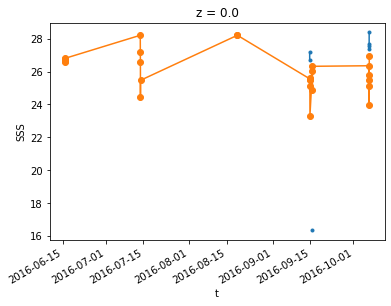

In [16]:
# plots to check... 
collocation_sss.plot(x='time', marker='.')
insitu.SSS.plot(marker='o')

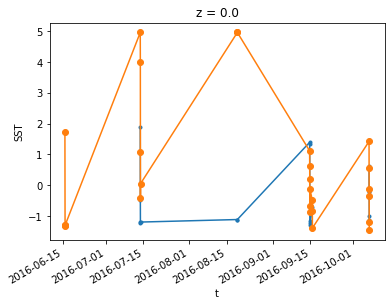

In [17]:
collocation_sst.plot(x='time', marker='.')
insitu.SST.plot(marker='o')

# SAVE output file

In [18]:
insitu['sss_smap']=collocation_sss
insitu['oisst']=collocation_sst
insitu

<xarray.Dataset>
Dimensions:    (t: 26, points: 26)
Coordinates:
    x          (t) float64 -150.0 -150.2 -150.0 -150.1 ... -150.0 -150.0 -150.0
    y          (t) float64 72.0 74.36 75.12 75.98 ... 74.01 74.98 76.02 77.05
    z          float64 0.0
  * t          (t) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:39:00
    longitude  (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    latitude   (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
    time       (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T22:...
    lon        (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    lat        (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
Dimensions without coordinates: points
Data variables:
    SSS        (t) float64 26.61 26.61 26.75 26.8 ... 25.13 23.96 25.78 26.96
    SST        (t) float64 1.719 -1.33 -1.302 -1.296 ... -0.356 -1.2 -1.458
    sss_smap   (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>
    oisst      (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>

In [19]:
ds=insitu.rename({'x': 'lon_insitu','y': 'lat_insitu','z': 'depth_insitu','t': 't_insitu',
                  'SSS': 'sss_insitu','SST': 'sst_insitu',
                  'time': 't_smap'})

In [20]:
ds = ds.drop(['longitude','latitude'])
ds

<xarray.Dataset>
Dimensions:       (t_insitu: 26, points: 26)
Coordinates:
    lon_insitu    (t_insitu) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0
    lat_insitu    (t_insitu) float64 72.0 74.36 75.12 ... 74.98 76.02 77.05
    depth_insitu  float64 0.0
  * t_insitu      (t_insitu) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-0...
    t_smap        (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T...
    lon           (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    lat           (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
Dimensions without coordinates: points
Data variables:
    sss_insitu    (t_insitu) float64 26.61 26.61 26.75 ... 23.96 25.78 26.96
    sst_insitu    (t_insitu) float64 1.719 -1.33 -1.302 ... -0.356 -1.2 -1.458
    sss_smap      (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>
    oisst         (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>

In [21]:
ds.sss_insitu.attrs['long_name'] = 'SIZR in situ salinity'
ds.sss_insitu.attrs['units'] = '1e-3'
ds.sst_insitu.attrs['long_name'] = 'SIZR in situ temperature'
ds.sst_insitu.attrs['units'] = 'degC'
ds

<xarray.Dataset>
Dimensions:       (t_insitu: 26, points: 26)
Coordinates:
    lon_insitu    (t_insitu) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0
    lat_insitu    (t_insitu) float64 72.0 74.36 75.12 ... 74.98 76.02 77.05
    depth_insitu  float64 0.0
  * t_insitu      (t_insitu) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-0...
    t_smap        (points) datetime64[ns] 2016-06-15T20:16:00 ... 2016-10-06T...
    lon           (points) float64 -150.0 -150.2 -150.0 ... -150.0 -150.0 -150.0
    lat           (points) float64 72.0 74.36 75.12 75.98 ... 74.98 76.02 77.05
Dimensions without coordinates: points
Data variables:
    sss_insitu    (t_insitu) float64 26.61 26.61 26.75 ... 23.96 25.78 26.96
    sst_insitu    (t_insitu) float64 1.719 -1.33 -1.302 ... -0.356 -1.2 -1.458
    sss_smap      (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>
    oisst         (points) float32 dask.array<chunksize=(26,), meta=np.ndarray>

In [22]:
# Save to Disk
fileout=str(output_dir) + '/SIZRS_SMAP_collocation_2016.nc'
ds.to_netcdf(fileout)